In [1]:
from __future__ import unicode_literals
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import re
from random import choice
from scipy.stats import describe
from collections import OrderedDict

### 1. A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. Haga una representación gráfica del grafo.

In [2]:
# data = []
# with open('data.csv', 'rw') as archivo:
#     for row in archivo:
#         data.append(list(map(lambda x: x.lower(), row.split(', ')[:4])))
    
# df = pd.DataFrame(data, columns=['year','opcode', 'field', 'authors'])
# df.to_pickle('data.df')
df = pd.read_pickle('data.df')
df.head(10)

,year,opcode,field,authors
0,1992,b368,nucl.phys.,horne & horowitz
1,1992,b278,phys. lett.,mikovic
2,1991,a6,mod. phys. lett.,huitu & nemeschansky
3,1992,b373,nucl.phys.,witten
4,1991,a6,mod.phys.lett.,intriligator
5,1991,a6,mod. phys. lett.,ooguri & sasakura
6,1992,a7,int. j. mod. phys.,leclair & smirnov
7,1992,b372,nucl.phys.,griffin
8,1992,b274,phys. lett.,sen
9,1992,b372,nucl.phys.,lerche & smit & warner


In [3]:
def get_pares(lista):
    return [(lista[x],lista[y]) for x in range(len(lista)) for y in range(x+1,len(lista))]

In [4]:
nodos = []
basura = ['italy', 'theorique', 'firenze', 'fisica', 'switzerland', 'pisa', 'cambridge', 'uk', 'infn', 'naples', 'damtp']
for col in df.index:
    nodos += list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
nodos = [nodo for nodo in nodos if nodo.lower() not in basura]
nodos = set(nodos)
G = nx.MultiGraph()
G.add_nodes_from(nodos)
for col in df.index:
    a = list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
    G.add_edges_from(get_pares(a))

In [5]:
print 'Cantidad de nodos:', G.number_of_nodes()
print 'Cantidad de aristas:', G.number_of_edges()
# print G.nodes()
# print G.degree

Cantidad de nodos: 3943
Cantidad de aristas: 13205


In [6]:
def NodosEscalados(G, n_max):
    '''
    Dado un grafo devuelve un subgrafo de a lo sumo n_max nodos
    que intenta respetar las proporciones de los grados de los nodos
    en el grafo original (remueve nodos aislados).
    
    Input:
    G = grafo
    prop_por_grado[i]: nodos de grado[i] / nodos_en_grafo
    n_max: maxima cantidad de nodos que puede tener el subgrafo generado
    '''
    nodos_subgrafo = []
    
    degree_sequence = list(sorted(map(lambda x: x[1], nx.degree(G)), reverse=True))
    prop_por_grado = [x/float(G.number_of_nodes()) for x in degree_sequence]
    
    nodos_que_faltan = [int(x*n_max) for x in prop_por_grado]
    
    for (nodo, grado) in G.degree():
        if grado == 0:
            continue
        if nodos_que_faltan[grado] > 0:
            nodos_subgrafo.append(nodo)
            nodos_que_faltan[grado] -= 1
    
    return nodos_subgrafo

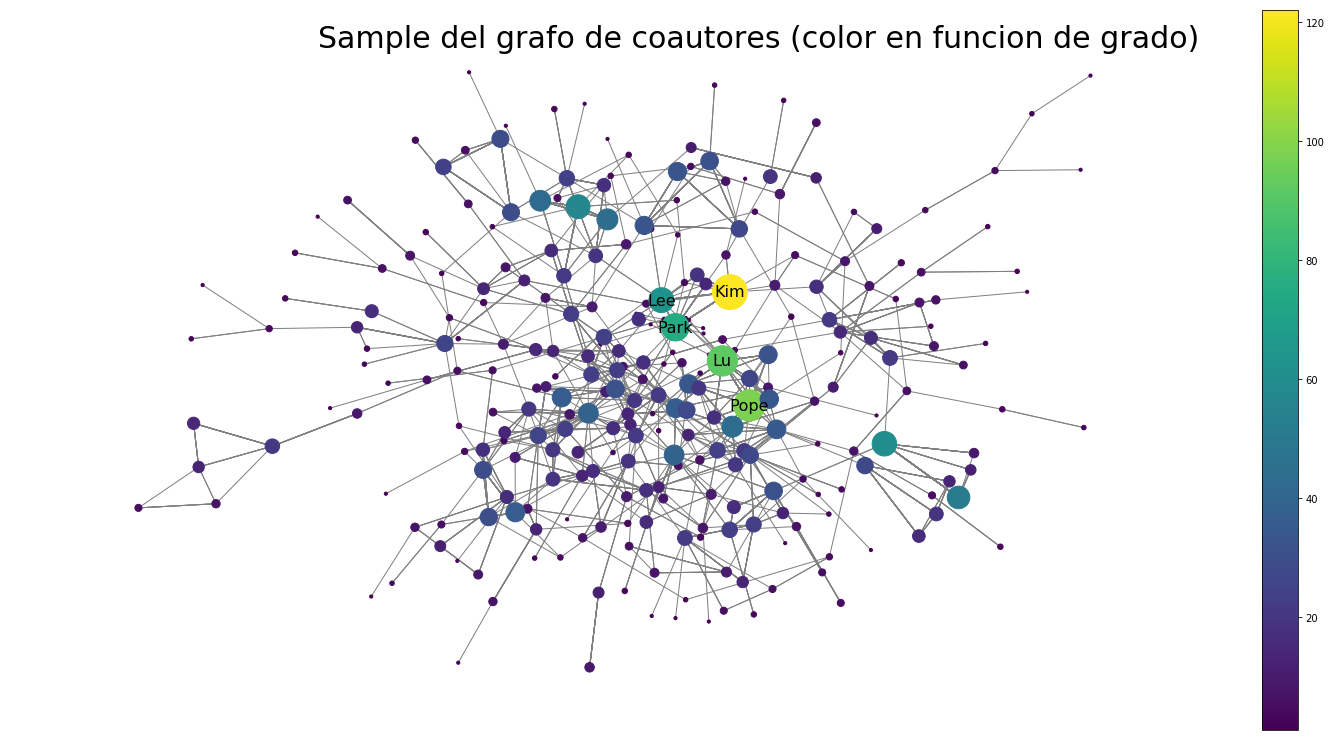

In [7]:
#Genero un subgrafo y saco los nodos con grado 0 en el subgrafo
subG = G.subgraph(NodosEscalados(G, 500))

#Filtro los nodos aislados en el subgrafo (no aportan al dibujo)
subG = G.subgraph(list(filter(lambda x: subG.degree(x)>0, subG.nodes())))
subG_grados = list((map(lambda x: x[1], nx.degree(subG))))
node_size = [x*10 for x in subG_grados]

labels = {}
for (nodo, grado) in subG.degree():
    if grado > 60:
        labels[nodo] = nodo.capitalize()
    else:
        labels[nodo] = ""
        
c_map = plt.cm.viridis
vmin = min(subG_grados)
vmax = max(subG_grados)

plt.clf()
fig = plt.figure(figsize=(20, 10))

nx.draw_kamada_kawai(subG, node_size=node_size, labels=labels, 
                     edge_color="grey", cmap=c_map, node_color=subG_grados, font_size=16)


sm = plt.cm.ScalarMappable(cmap=c_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

fig.suptitle("Sample del grafo de coautores (color en funcion de grado)", fontsize=30)
plt.show()

### 2. Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica, y log-log. Argumente, a partir de los gráficos, de qué tipo de distribución se trata.

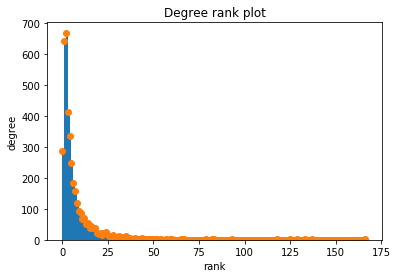

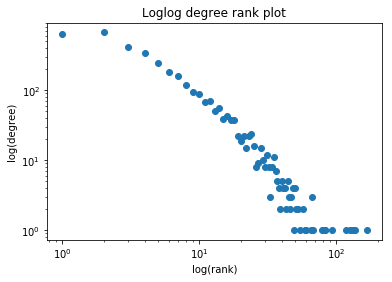

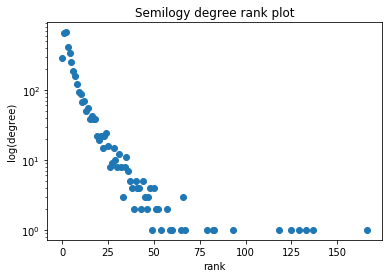

In [8]:
degree_sequence = list(sorted(map(lambda x: x[1], nx.degree(G)), reverse=True)) # degree sequence
bins = plt.hist(degree_sequence, bins=max(degree_sequence))
 
plt.plot(bins[0], 'o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

plt.loglog(bins[0], 'o')
plt.title("Loglog degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("log(rank)")
plt.show()

plt.semilogy(bins[0], 'o')
plt.title("Semilogy degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("rank")
plt.show()


Solamente observando la distribución de los grados no podemos afirmar si se trata de una distribución exponencial o de una de Ley de potencias. Para poder determinarlo entonces ploteamos los gráficos loglog y semilog para intentar encontrar alguna diferencia. Observando los gráficos realizados vemos que ignorando los puntos iniciales el gráfico loglog muestra un comportamiento lineal de los datos, mientras que en el gráfico semilog se puede ver una curvatura en los datos.

A partir de este análisis cuantitativo consideramos que la distribución de los grados de los vértices del grafo en función de su rank es la de una ley de potencias.

### 3. Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante.


In [24]:
c_gigante_size, c_gigante_elems = sorted(list(map(lambda x: (len(x), x), nx.connected_components(G)))
                                        , reverse=True)[0]

print "Cantidad de componentes conexas del grafo: {}".format(nx.number_connected_components(G))
print "Tamaño de la componente gigante: {} nodos de {}".format(c_gigante_size,G.number_of_nodes())

Cantidad de componentes conexas del grafo: 506
Tamaño de la componente gigante: 3026 nodos de 3943


### 4. Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla. Grafique el número de autores alcanzados en función de la distancia al nodo semilla. Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función. Pruebe con varios nodos semillas y analice la robustez de este resultado. Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación.

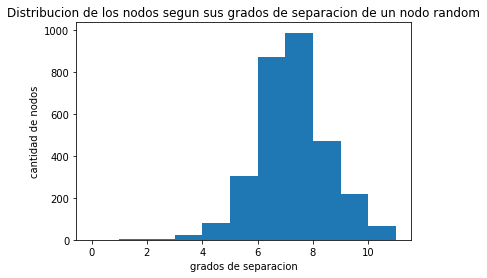

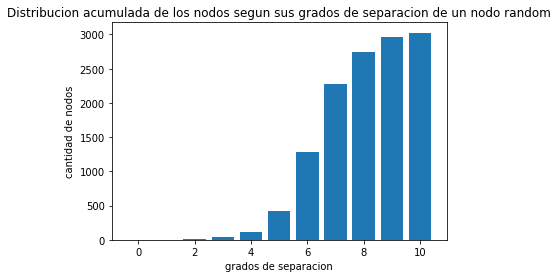

DescribeResult(nobs=3026, minmax=(0, 11), mean=6.7524785194976866, variance=1.7486302185467, skewness=-0.03563795420475035, kurtosis=0.9864135896900326)


In [28]:
#Creo el grafo que es solo la componente gigante
G_gigante = G.subgraph(c_gigante_elems)

seed_node = choice(list(G_gigante.nodes()))
distancias = nx.shortest_path_length(G, source=seed_node).values()
hist = plt.hist(distancias, bins=max(distancias))
plt.title("Distribucion de los nodos segun sus grados de separacion de un nodo random")
plt.ylabel("cantidad de nodos")
plt.xlabel("grados de separacion")
plt.show()

histograma, indices = np.histogram(distancias, bins=max(distancias))
acumulado = np.copy(histograma)
for i in range(len(histograma)):
    acumulado[i] = np.sum(histograma[:i+1])
plt.bar(indices[:-1], acumulado)
plt.title("Distribucion acumulada de los nodos segun sus grados de separacion de un nodo random")
plt.ylabel("cantidad de nodos")
plt.xlabel("grados de separacion")
plt.show()

print describe(np.array(distancias))

Luego de probarlo con a partir de un nodo random, veamos los grados de separacion a partir de varios nodos semilla para ver como varía.

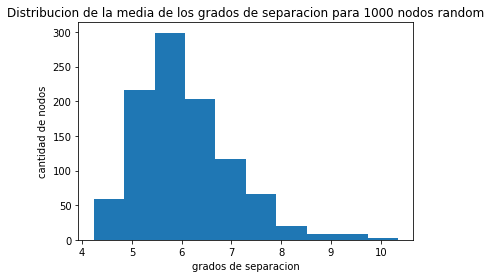

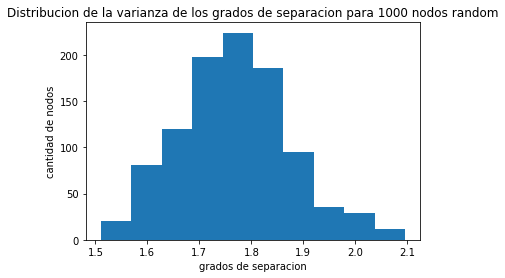

In [30]:
# Veamos la distribucion para muchos random
G_gigante = G.subgraph(c_gigante_elems)

cant = 1000
medias = []
varianzas = []
for i in range(cant):
    seed_node = choice(list(G_gigante.nodes()))
    distancias = nx.shortest_path_length(G, source=seed_node).values()
    medias.append(describe(np.array(distancias)).mean)
    varianzas.append(describe(np.array(distancias)).variance)

plt.hist(medias)
plt.title("Distribucion de la media de los grados de separacion para 1000 nodos random")
plt.ylabel("cantidad de nodos")
plt.xlabel("grados de separacion")
plt.show()

plt.hist(varianzas)
plt.title("Distribucion de la varianza de los grados de separacion para 1000 nodos random")
plt.ylabel("cantidad de nodos")
plt.xlabel("grados de separacion")
plt.show()


Los graficos parecen corresponderse con el fenómeno de los seis grados de separación, ya que en este valor, la cantidad de autores accesibles agregados llega a su pico máximo, y baja considerablemente para los siguientes valores, siendo pocos los nuevos autores que se agregan sin importar los grados de separación agregados.

### 5. Mundos Pequeños Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante. Genere un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo. Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

In [31]:
G_gigante_grafo = nx.Graph(G.subgraph(c_gigante_elems)) #lo hago grafo porque el clustering promedio no anda sino

avg_clustering = nx.average_clustering(G_gigante_grafo)
# print nx.average_shortest_path_length(G_gigante_grafo) # ojo que esto tarda una bocha
avg_shorted_path_length_harcodeado = 6.08460515751
print 'Clustering promedio', avg_clustering
print 'Camino minimo promedio', avg_shorted_path_length_harcodeado

Clustering promedio 0.482143695341
Camino minimo promedio 6.08460515751


In [13]:
# secuencia_grafica = [G_gigante.degree(nodo) for nodo in G_gigante.nodes()]
# random_graph = nx.random_degree_sequence_graph(secuencia_grafica)
# nx.write_gpickle(random_graph, 'random_graph.gf')
random_graph = nx.read_gpickle('random_graph.gf')

In [14]:
# Veamos las 2 cc del grafo random
for g in nx.connected_component_subgraphs(random_graph): 
    print 'CC'
    print 'Ejes:', g.number_of_edges(), ', Nodos:', g.number_of_nodes()

CC
Ejes: 12473 , Nodos: 3024
CC
Ejes: 1 , Nodos: 2


El grafo aleatorio generado tiene dos componentes conexa y necesita tener una sola para poder calcularle camino minimo promedio. Sin embargo una de las dos c.c. contiene solamente 2 nodos y 1 eje, por lo tanto resulta despreciable comparandolo con la otra c.c. de 3024 nodos.

In [32]:
avg_clustering_random = nx.average_clustering(random_graph)
print 'Clustering promedio', avg_clustering_random

#el random no es conexo asi que hacemos caminimo de la c.c. mas grande, la otra es casi el grafo trivial
g_random_conexa = sorted(nx.connected_component_subgraphs(random_graph), key=len, reverse=True)[0]
print 'Camino minimo promedio', nx.average_shortest_path_length(g_random_conexa)
# avg_shorted_path_length_random = nx.average_shortest_path_length(random_graph)


Clustering promedio 0.0159144061105
Camino minimo promedio 3.65371087973


Comparando los resultados podemos ver que el clustering en nuestro grafo es más de 30 veces más grande que el de el grafo random mientras que el camino mínimo promedio no llega a ser el doble, y su valor no parece ser muy grande.
Los resultados son bastante similares a los ejemplos de mundos pequeños vistos en clase: un clustering promedio bajo pero con caminos mínimos cortos. Por lo tanto, suponemos que se trata de un grafo con estructura de mundos pequeños.

### 6. Estrellas. Discuta cómo haría para individuar a los autores “estrella” del campo. Evalúe quiénes son estos autores según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca la componente gigante del grafo.

#### 1ra medida: betweenness centrality

In [16]:
betweenness = nx.betweenness_centrality(G, normalized=True)

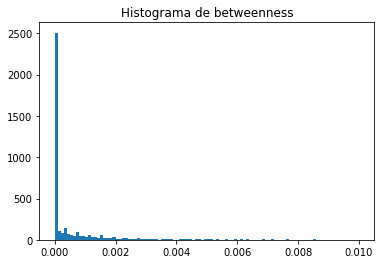

2256


In [17]:
plt.hist(list(betweenness.values()), bins=100, range=(0,0.01))
plt.title("Histograma de betweenness")
plt.show()
print len([x for x in betweenness.values() if x==0])

Vemos que la mayoria de los nodos (2256) tienen betweenness centrality 0.

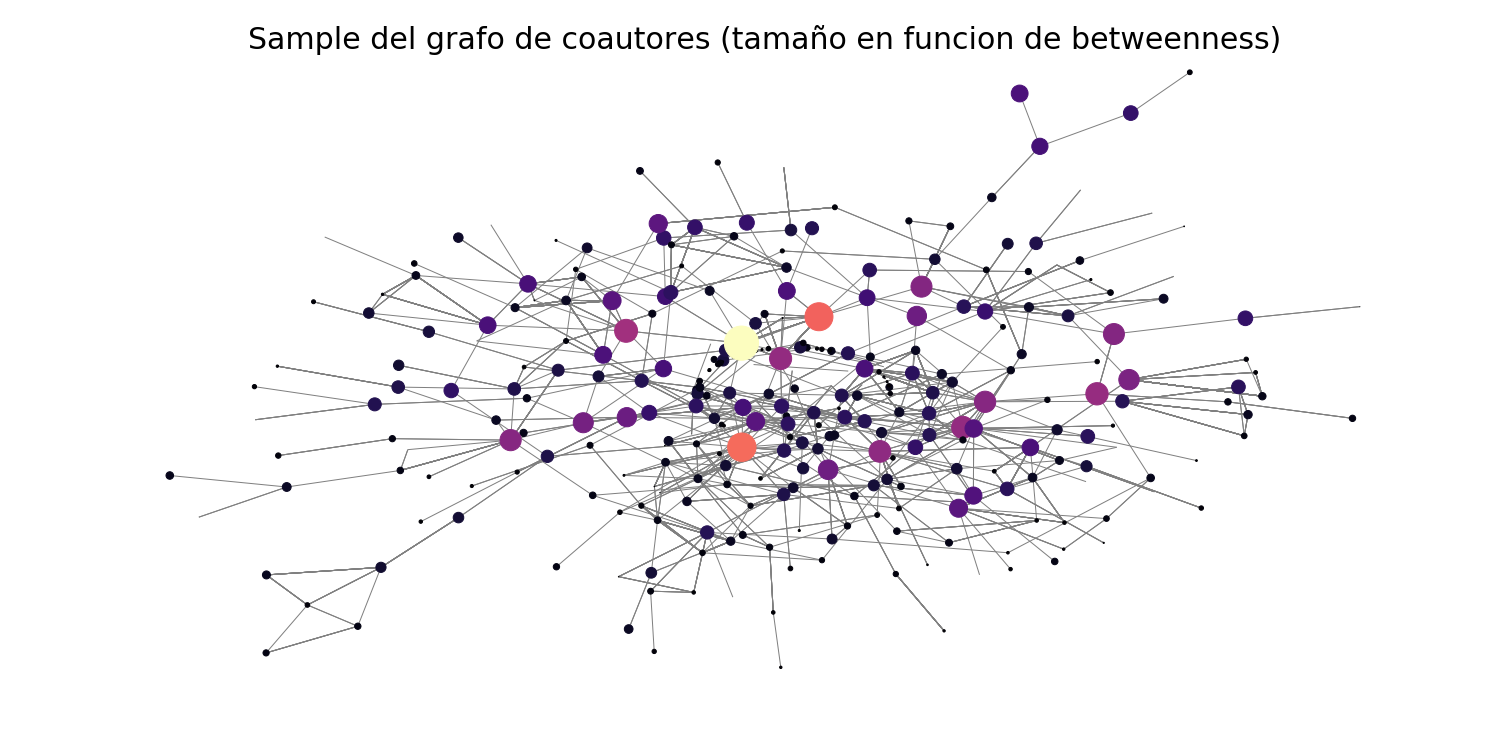

In [18]:
#Genero un subgrafo y saco los nodos con grado 0 en el subgrafo
subG = G.subgraph(NodosEscalados(G, 500))

subG_grados = list((map(lambda x: x[1], nx.degree(subG))))
node_size = [25000*betweenness[x] for x in subG.nodes()]

labels = {}
for nodo in betweenness.keys():
    btw = betweenness[nodo]
    if not(nodo in subG.nodes()):
        continue
        
    if btw > 0.2:
        labels[nodo] = nodo.capitalize()
    else:
        labels[nodo] = ""
        
c_map = plt.cm.magma
vmin = 0
vmax = 1

plt.clf()
fig = plt.figure(figsize=(20, 10))

nx.draw_kamada_kawai(subG, node_size=node_size, labels=labels, 
                     edge_color="grey", cmap=c_map, node_color=[x/20000 for x in node_size], font_size=16)


sm = plt.cm.ScalarMappable(cmap=c_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
# plt.colorbar(sm)

fig.suptitle("Sample del grafo de coautores (tamaño en funcion de betweenness)", fontsize=30)
plt.show()

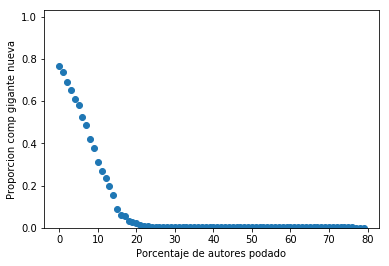

In [36]:
autores_estrella = []

eje_x = [float(x)/100 for x in range(0,80)]
eje_y = []
for i in eje_x:
    autores_restantes = int(G.number_of_nodes() * i)

    sorted_btw = sorted(betweenness.items(),key=lambda x: x[1], reverse=True)
    while autores_restantes > 0:
        autores_estrella.append(sorted_btw[0])
        sorted_btw.pop(0)
        autores_restantes-=1

    grafo_sin_estrellas = G.subgraph([x[0] for x in sorted_btw])

    c_gigante_size, c_gigante_elems = sorted(list(map(lambda x: (len(x), x),
                                            nx.connected_components(grafo_sin_estrellas))), reverse=True)[0]
    eje_y.append(c_gigante_size)

plt.plot(list(map(lambda a: (100 * a),eje_x)), [float(y)/G.number_of_nodes() for y in eje_y], 'o')
# plt.plot(eje_x, [float(eje_y[i])/(G.number_of_nodes() * (1-eje_x[i])) for i in range(len(eje_y))], 'o')

plt.ylim(0,1.03)
plt.xlabel("Porcentaje de autores podado")
plt.ylabel("Proporcion comp gigante nueva")
plt.show()

Vamos sacando del grafo a los autores de mayor betweenness centrality y vemos como varia el tamaño de la componente conexa gigante. Se observa que a medida que sacamos nodos, el tamaño de la componente gigante nueva va descendiendo linealmente hasta que sacamos el 15% más central. A partir de allí, la componente conexa de mayor tamaño representa una proporción muy pequeña del total de nodos.

#### 2ra medida: eigenvector centrality

In [20]:
G = nx.Graph(G)
eigenvector = nx.eigenvector_centrality(G)

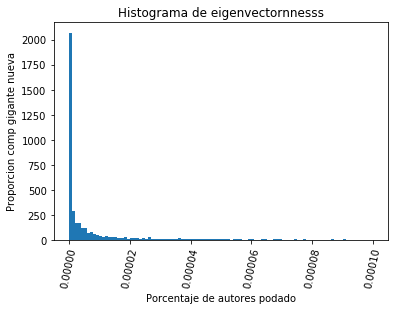

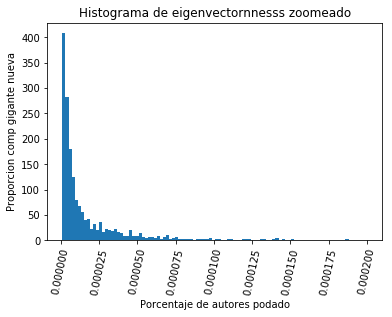

0


In [21]:
plt.hist(list(eigenvector.values()), bins=100, range=(0,0.0001))
ax = plt.gca()
plt.title("Histograma de eigenvectornnesss")
plt.xlabel("Porcentaje de autores podado")
plt.ylabel("Proporcion comp gigante nueva")
for tick in ax.get_xticklabels():
    tick.set_rotation(78)
plt.show()


plt.hist(list(eigenvector.values()), bins=100, range=(0.000001101,0.0002))
ax = plt.gca()
plt.title("Histograma de eigenvectornnesss zoomeado")
plt.xlabel("Porcentaje de autores podado")
plt.ylabel("Proporcion comp gigante nueva")
for tick in ax.get_xticklabels():
    tick.set_rotation(78)
plt.show()
print len([x for x in eigenvector.values() if x==0])

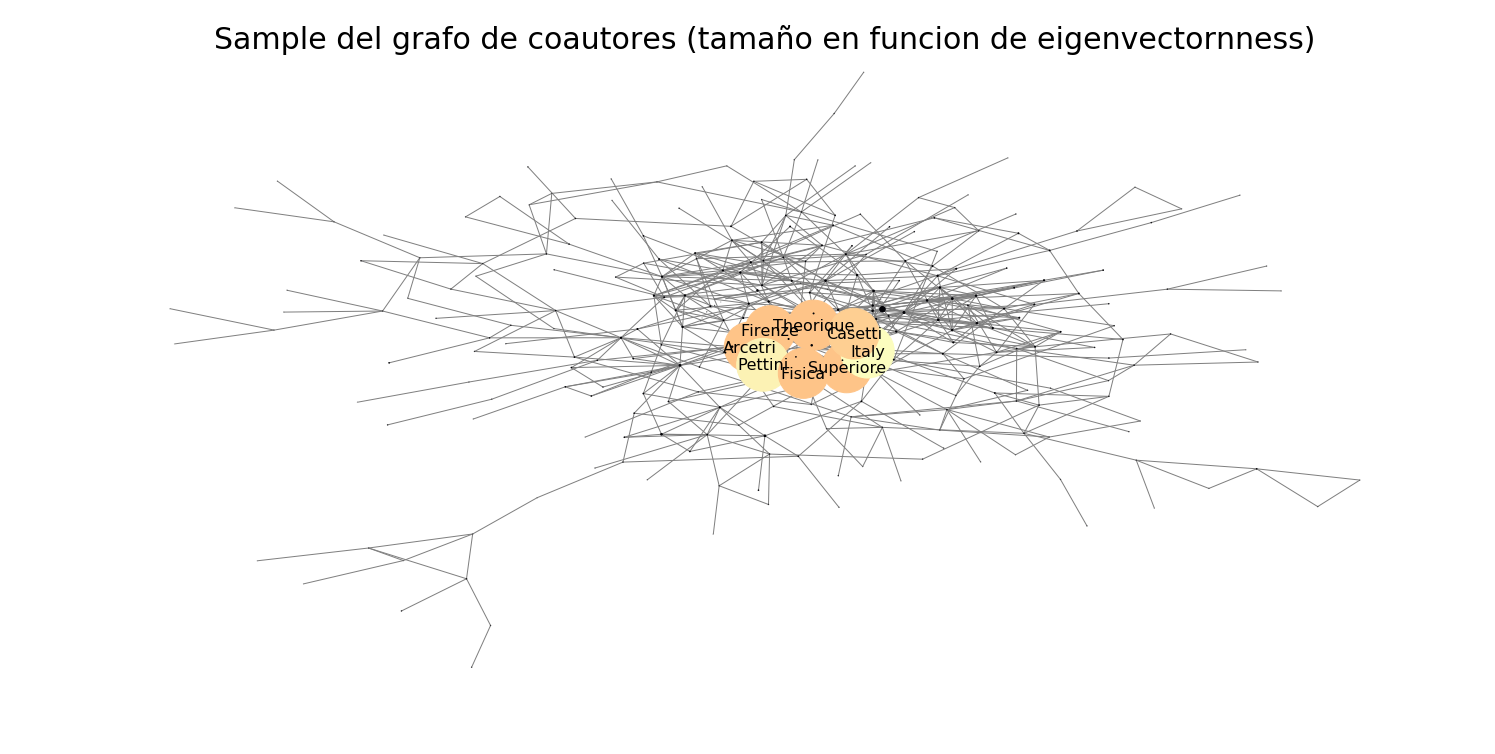

In [22]:
#Genero un subgrafo y saco los nodos con grado 0 en el subgrafo
sorted_eigenvector = sorted(eigenvector.items(),key=lambda x: x[1], reverse=True)

# subG = G.subgraph([x[0] for x in sorted_eigenvector[:int(len(sorted_eigenvector)*0.1)]])
subG = G.subgraph(NodosEscalados(G, 2200))


node_size = [10000 * eigenvector[x] for x in subG.nodes()]

labels = {}
for nodo in eigenvector.keys():
    btw = eigenvector[nodo]
    if not(nodo in subG.nodes()):
        continue
        
    if btw > 0.2:
        labels[nodo] = nodo.capitalize()
    else:
        labels[nodo] = ""
        
c_map = plt.cm.magma
vmin = 0
vmax = 1

plt.clf()
fig = plt.figure(figsize=(20, 10))

nx.draw_kamada_kawai(subG, node_size=node_size, labels=labels, 
                     edge_color="grey", cmap=c_map, node_color=node_size, font_size=16)


sm = plt.cm.ScalarMappable(cmap=c_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
# plt.colorbar(sm)

fig.suptitle("Sample del grafo de coautores (tamaño en funcion de eigenvectornness)", fontsize=30)
plt.show()

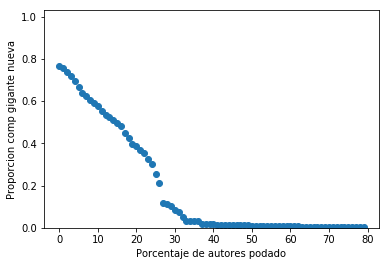

In [37]:
eigen_estrella = []

eje_x = [float(x)/100 for x in range(0,80)]
eje_y = []
for i in eje_x:
    autores_restantes = int(G.number_of_nodes() * i)

    sorted_btw = sorted(eigenvector.items(),key=lambda x: x[1], reverse=True)
    while autores_restantes > 0:
        eigen_estrella.append(sorted_btw[0])
        sorted_btw.pop(0)
        autores_restantes-=1

    grafo_sin_estrellas = G.subgraph([x[0] for x in sorted_btw])

    c_gigante_size, c_gigante_elems = sorted(list(map(lambda x: (len(x), x),
                                            nx.connected_components(grafo_sin_estrellas))), reverse=True)[0]
    eje_y.append(c_gigante_size)

plt.plot(list(map(lambda a: (100 * a),eje_x)), [float(y)/G.number_of_nodes() for y in eje_y], 'o')
# plt.plot(eje_x, [float(eje_y[i])/(G.number_of_nodes() * (1-eje_x[i])) for i in range(len(eje_y))], 'o')

plt.ylim(0,1.03)
plt.xlabel("Porcentaje de autores podado")
plt.ylabel("Proporcion comp gigante nueva")
plt.show()

Vamos sacando del grafo a los autores de mayor centralidad y vemos como varia el tamaño de la componente conexa gigante en relacion con el total de nodos. El grafico resulta similar al de betweenness centrality: hay un descenso lineal hasta cierto punto cercano a 0 y a partir de ahí se mantiene mas o menos constante.
Sin embargo, en este caso el descenso lineal termina luego se podar cerca del 30% de los autores (en el otro era 15%). Creemos que sacar a nodos de mayor betweenness centrality elimina la componente conexa más rapido justamente por como se determina su centralidad. La betweenness centrality está relacionada con caminos que pasan por él por lo que los nodos "puente" (que al sacarlos agregan una componente conexa al grafo) tendrán centralidad alta.